# What is this?
In this file I piece together all of the components from the previous jupyter notebooks. 

The below code was edited from code I found on a [reddit post](https://www.reddit.com/r/dailyprogrammer/comments/3snorf/20151113_challenge_240_hard_kenken_solver/). 

In [63]:
from functools import reduce
import operator

def check(board, cage_map, cell, i):
    val, op, coords = cage_map[cell]
    vals = [board[coord] for coord in coords]
    if not all(vals):
        return True
    if op == "=":
        return i == val
    elif op == "+":
        return sum(vals) == val
    elif op == "*":
        return reduce(operator.mul, vals) == val
    elif op == "-":
        return abs(vals[0] - vals[1]) == val
    elif op == "/":
        bigger, smaller = max(vals), min(vals)
        return bigger % smaller == 0 and bigger // smaller == val

def recurse(sz, cage_map, board, cell_list, depth=0):
    if depth == len(cell_list):
        return True
    cell = cell_list[depth]
    X, Y = cell
    used = {board[(x, Y)] for x in range(sz)} | {board[(X, y)] for y in range(sz)}
    for i in set(range(1, sz+1)) - used:
        board[cell] = i
        if not check(board, cage_map, cell, i):
            continue
        if recurse(sz, cage_map, board, cell_list, depth+1):
            return True
    board[cell] = None

def read_file(file_name):
    sz, *cages = open(file_name).read().splitlines()
    sz = int(sz)

    name_to_coord = lambda name: ('ABCDEFGHI'.index(name[0]), int(name[1])-1)
    cages = [
        (int(val), operator, [name_to_coord(coord) for coord in coords])
        for val, operator, *coords in map(str.split, cages)
    ]
    
    cage_map = {
        coord: cage
        for cage in cages
        for coord in cage[2]
    }

    board = {
        coord: None for coord in cage_map
    }
    cell_list = list(sorted(board))
    
    return sz, cage_map, board, cell_list
    

def solve_puzzle(file_name, verbose=False):
    sz, cage_map, board, cell_list = read_file(file_name)
    recurse(sz, cage_map, board, cell_list)

    if verbose:
        for y in range(sz):
            line = " ".join(str(board[(x, y)]) for x in range(sz))
            print(line)
    else:
        return board
        
print('Puzzle 1:')
solve_puzzle("puzzle.txt", True)
print('Puzzle 2:')
solve_puzzle("puzzle2.txt", True)

Puzzle 1:
1 4 3 5 2 6
3 5 2 6 4 1
4 6 1 3 5 2
5 3 6 2 1 4
6 2 4 1 3 5
2 1 5 4 6 3
Puzzle 2:
3 2 1 4
4 1 3 2
2 3 4 1
1 4 2 3


Let's put everthing together now so we can get a **text file** lke those used in the above code.

## Finding Clusters

In [64]:
from collections import defaultdict
from copy import deepcopy
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from scipy.misc import imsave

from skimage import feature
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import erosion, dilation, rectangle, square
from skimage.measure import find_contours

from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import tensorflow as tf

%matplotlib inline


In [65]:
IMAGE_FILE = 'sample4x4_3.jpg'

In [66]:
def binarize(matrix, threshold=0.3):
    temp = deepcopy(matrix)
    for m in range(len(temp)):
        for n in range(len(temp[m])):
            if temp[m][n] < threshold:
                temp[m][n] = 0.0
            else:
                temp[m][n] = 1.0
                
    return temp

choosing  (25, 25)
currently labeled  []
path found :  [(25, 75), (25, 25)]
assigning label :  1 

choosing  (25, 75)
currently labeled  [(25, 75), (25, 25)]
its already in the set
choosing  (25, 125)
currently labeled  [(25, 75), (25, 25)]
path found :  [(25, 125), (75, 175), (25, 175)]
assigning label :  2 

choosing  (25, 175)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175)]
its already in the set
choosing  (75, 25)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175)]
path found :  [(125, 25), (75, 25)]
assigning label :  3 

choosing  (75, 75)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175), (125, 25), (75, 25)]
path found :  [(75, 75), (125, 75)]
assigning label :  4 

choosing  (75, 125)
currently labeled  [(25, 125), (25, 75), (75, 175), (75, 75), (25, 25), (125, 75), (25, 175), (125, 25), (75, 25)]
path found :  [(175, 125), (125, 125), (75, 125)]
assigning label :  5 

choosing  (75, 175)
currently labeled  [(

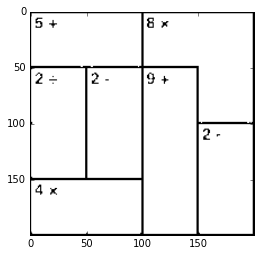

In [89]:
###########################
#####IMPORT THE IMAGE######
###########################
sample4x4_orig = ndi.imread(IMAGE_FILE, mode='L')
sample4x4 = resize(sample4x4_orig, (200,200))
#plt.imshow(sample4x4, cmap=mpl.cm.Greys_r)

binar = deepcopy(sample4x4)
binar = binarize(binar)
#plt.imshow(binar, cmap=mpl.cm.Greys_r)

###########################
#####CROP THE IMAGE########
###########################
# up left
cond = False
for m in range(7):
    for n in range(7):
        if binar[m][n] == 0:
            up_left = [m,n]
            cond = True
            break
    if cond==True:
        break
        
# low right
cond = False
for m in range(199,192,-1):
    for n in range(199,192,-1):
        #print(m,n, binar[m][n])
        if binar[m][n] == 0:
            low_right = [m,n]
            cond = True
            break
    if cond==True:
        break

sample4x4_crop = resize(sample4x4[up_left[0]:low_right[0]+1,up_left[1]:low_right[1]+1], (200,200))
binar = binarize(sample4x4_crop)
plt.imshow(binar, cmap=mpl.cm.Greys_r)

################################################
#####APPLY FILTERS TO REMOVE NUM/SYMBOLS########
################################################
selem = rectangle(2,2)
dil = dilation(binar, selem)
#dil = erosion(dil)
#plt.imshow(dil, cmap=mpl.cm.Greys_r)

dil = binarize(dil)
#plt.imshow(dil, cmap=mpl.cm.Greys_r)

cluster_image = deepcopy(dil)

for i in range(4):
    for j in range(4):
        cluster_image[i*50+5:i*50+40,j*50+3:j*50+38] = np.zeros((35,35))+1

#plt.imshow(cluster_image, cmap=mpl.cm.Greys_r)

##################################
#####GET CLUSTER LOCATIONS########
##################################

#GENERATE CENTERS OF EACH BOX
CENTROIDS = [[[25+50*i,25+50*j] for j in range(0,4)] for i in range(0,4)]

#LINK BOX CENTERS TO GRID LOCATIONS I.E. (25,175) = (0,3)
CLUSTER_LOC_DICT = defaultdict(list)

for m in range(len(CENTROIDS)):
    for n in range(len(CENTROIDS[m])):
        CLUSTER_LOC_DICT[tuple(CENTROIDS[m][n])] = (m,n)

#CREATE A DICTIONARY OF THE LOCATIONS OF NEIGHBORS OF EACH BOX
NEIGHBOR_PAIRS = []

for m in range(len(CENTROIDS)):
    for n in range(len(CENTROIDS[m])):
        #skip right edge
        if n < (len(CENTROIDS[m])-1):
            NEIGHBOR_PAIRS.append([CENTROIDS[m][n], CENTROIDS[m][n+1]])
        #skip bottom edge
        if m < (len(CENTROIDS)-1):
            NEIGHBOR_PAIRS.append([CENTROIDS[m][n], CENTROIDS[m+1][n]])
        #skip top edge
        if m > 0:
            NEIGHBOR_PAIRS.append([CENTROIDS[m][n], CENTROIDS[m-1][n]])
        #skip left edge
        if n > 0:
            NEIGHBOR_PAIRS.append([CENTROIDS[m][n], CENTROIDS[m][n-1]]) 

NEIGHBORS_DICT = defaultdict(list)

for link in NEIGHBOR_PAIRS:
    NEIGHBORS_DICT[tuple(link[0])].append(link[1])

    
#CREATE CLASS FOR WALKING THROUGH IMAGE AND RETURNING 
class cluster_grouper(object):
    
    def __init__ (self, image):
        self.image_arr = image
        # unique_label is the current # of unique labels used
        self.unique_label = 1

        # labeled_boxes keeps track of the boxes that have already been labeled
        self.labeled_boxes = []

        # create label_dict to store each boxes location
        self.label_dict = {tuple(v):0 for _,v in CLUSTER_LOC_DICT.items()}
                
    
        
    def check_neighbors(self, box_to_check, path=[]):
    #if neighbor is unlabeled and connected, 
    #step to that one, 
    #append current cell to path, 
    #call check neighbors
        #check neighbors to see if any paths are blocked append T/F to if path blocked
        if box_to_check not in path:
            path.append(box_to_check)
        
        for neighbor in NEIGHBORS_DICT[box_to_check]:
            # print(neighbor)
            # skip a neighbor that you've come from
            if tuple(neighbor) not in path:
                top = box_to_check[0]
                bottom = neighbor[0]
                left = box_to_check[1]
                right = neighbor[1]
                
                # need to check if top/bottom or left/right are same value, need to add 1
                if top == bottom:
                    bottom +=1
                if left == right:
                    right +=1
                    
                # also swap top/bottom or left/right if matching upwards or leftwards
                if right < left:
                    left,right = right,left
                if top > bottom:
                    top,bottom = bottom,top
                
                # if there is a black pixel in path, skip
                if 0 in self.image_arr[top:bottom,left:right].flatten():
                    continue
                # else check the neighbor and extend path of result recursively
                else:
                    path.extend(self.check_neighbors(tuple(neighbor), path))
                    path = list(set(path))
                               
        return path
    
    def execute(self):
        for box in sorted(NEIGHBORS_DICT.keys(), key=lambda x: x):
            #only clusters that haven't been labeled should appear not labeled,
            #once an unlabeled cluster is found, all boxes in that cluster should be labeled
            print('choosing ',box)
            print('currently labeled ',self.labeled_boxes)
            if box not in self.labeled_boxes:
                #print(box)
                connected_path = self.check_neighbors(box, path=[])
                #get only unique boxes
                print('path found : ', connected_path)
                connected_path = set(connected_path)
                #assign each box in the path a label
                for connected_box in connected_path:
                    self.label_dict[CLUSTER_LOC_DICT[connected_box]] = self.unique_label
                    self.labeled_boxes.append(tuple(connected_box))
                #increment the label
                print('assigning label : ',self.unique_label, '\n')
                self.unique_label += 1
            else:
                print('its already in the set')
            
            self.labeled_boxes = list(set(self.labeled_boxes))
        return self.label_dict

#PASS THE CLUSTER IMAGE TO A NEW INSTANCE OF THE CLUSTER_GROUPER AND EXECUTE
#THIS WILL RETURN A DICTIONARY WITH THE CLUSTER LABEL(VALUE) FOR EACH BOX(KEY)
cluster_groupings_dict = cluster_grouper(cluster_image).execute()




## Identifying the numbers with TensorFlow

2 numbers/symbols found in quadrant 0,0
0 numbers/symbols found in quadrant 0,1
2 numbers/symbols found in quadrant 0,2
0 numbers/symbols found in quadrant 0,3
2 numbers/symbols found in quadrant 1,0
2 numbers/symbols found in quadrant 1,1
2 numbers/symbols found in quadrant 1,2
0 numbers/symbols found in quadrant 1,3
0 numbers/symbols found in quadrant 2,0
0 numbers/symbols found in quadrant 2,1
0 numbers/symbols found in quadrant 2,2
2 numbers/symbols found in quadrant 2,3
2 numbers/symbols found in quadrant 3,0
0 numbers/symbols found in quadrant 3,1
0 numbers/symbols found in quadrant 3,2
0 numbers/symbols found in quadrant 3,3
14 numbers/symbols found in image


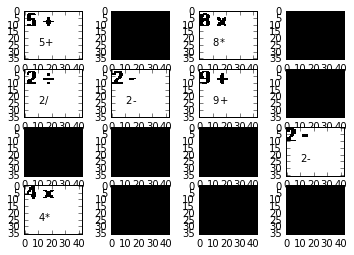

In [76]:
##############################################
#####IMPORT TENSOR FLOW GRAPH AND DATA########
##############################################

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
    

with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 14])
    W = tf.Variable(tf.zeros([784,14]))
    b = tf.Variable(tf.zeros([14]))

    #Inference
    with tf.name_scope('hidden1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(x, [-1,28,28,1])
        hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('hidden2'):
        h_pool1 = max_pool_2x2(hidden1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('fully_connected'):
        h_pool2 = max_pool_2x2(h_conv2)
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        fully_connected = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(fully_connected, keep_prob)

    with tf.name_scope('softmax'):
        W_fc2 = weight_variable([1024, 14])
        b_fc2 = bias_variable([14])
        y_conv=tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2)

    #Loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='xentropy')

    #Training
    tf.scalar_summary(cross_entropy.op.name, cross_entropy)
    global_step=tf.Variable(0,name='global_step',trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)

    #Evaluation
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #Prediction
    prediction = tf.argmax(y_conv,1)

    #Initialization
    sess = tf.Session()
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

    sess.run(init)

    #Restore
    saver.restore(sess,"model_newest.ckpt")
    
################################################################
#####PRE PROCESS THE IMAGE FOR ISOLATING NUMBERS/SYMBOLS########
################################################################
    
def pre_process_image(image_file):
    #get the image and resize
    image_data = ndi.imread(image_file, mode = 'L')
    resized_image = resize(image_data, (200,200))

    #apply the transformations from 01_basic_image_tests.ipynb
    binar = deepcopy(resized_image)
    binar = binarize(binar, 0.6)

    # Get the upleft and lowright black pixels for croping to corners
    # up left
    cond = False
    for m in range(10):
        for n in range(10):
            if binar[m][n] == 0:
                up_left = [m,n]
                cond = True
                break
        if cond==True:
            break

    # low right
    cond = False
    for m in range(199,189,-1):
        for n in range(199,189,-1):
            #print(m,n, binar[m][n])
            if binar[m][n] == 0:
                low_right = [m,n]
                cond = True
                break
        if cond==True:
            break

    resized_image = resize(resized_image[up_left[0]:low_right[0]+1,up_left[1]:low_right[1]+1], (200,200))
    binar = binarize(resized_image, 0.4)

    undilated = deepcopy(binar)

    #dilate the binarized image
    selem = rectangle(1,2)
    dil = dilation(binar, selem)

    #binarize dilation
    dil = binarize(dil)

    #final = dil

    final = deepcopy(dil)
    for i in range(4):
        for j in range(4):
            final[i*50+3:i*50+25,j*50+3:j*50+44] = undilated[i*50+3:i*50+25,j*50+3:j*50+44]

    #Try to remove all borders and grid lines in the image. 
    #Do this by scanning over rows and cols and if more than 25%
    #of the pixels are <= 0.45 then set the entire row to 1(white)

    #first rows
    for row in range(len(final)):
        count = 0
        for pixel in final[row,:]:
            if pixel == 0:
                count += 1
        if count >= 48:
            final[row,:] = final[row,:]*0 + 1

    #columns
    for col in range(len(final[0,:])):
        count = 0
        for pixel in final[:,col]:
            if pixel == 0:
                count += 1
        if count >= 48:
            final[:,col] = final[:,col]*0 + 1
            
    #add some final erosion (black) to fill out numbers and ensure they're connected
    final = binarize(erosion(final, rectangle(1,2)),.0000001)
    
    return final

#APPLY PRE PROCESS TO DESIRED IMAGE
final = pre_process_image(IMAGE_FILE)


#the regions in the image that will be searched for contours
REGIONS_OF_INTEREST = [final[3:39,3:46],
                      final[3:39,53:96],
                      final[3:39,103:146],
                      final[3:39,153:196],
                      final[53:89,3:46],
                      final[53:89,53:96],
                      final[53:89,103:146],
                      final[53:89,153:196],
                      final[103:139,3:46],
                      final[103:139,53:96],
                      final[103:139,103:146],
                      final[103:139,153:196],
                      final[153:189,3:46],
                      final[153:189,53:96],
                      final[153:189,103:146],
                      final[153:189,153:196]
                      ]

#CONVERSION used for converting the index of the argmax returned
#from tensorflow into a string value
CONVERSION = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'*', 11:'+',12:'-',13:'/'}


def get_predictions(final):
    ################################################################
    #####ISOLATE LOCATIONS OF EACH NUM/SYM IN EACH BOX############## 
    #####       AND PREDICT USING TENSOR FLOW         ##############
    ################################################################

    #get the contour lines and make a bounding box of each contour
    total_images_found = 0
    fig = plt.figure()

    #x_count and y_count is used for plotting the images
    #and also for saving the results to prediction_dict
    x_count = 0
    y_count = 0
    prediction_dict = defaultdict(list)
    plot_counter = 1

    for region in REGIONS_OF_INTEREST:  
        #Results is where the sub-ROIs will be stored
        results = []
        ctrs = find_contours(region, .9)
        rects = [np.array(
                [[min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
                 [min(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
                 [max(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
                 [max(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
                 [min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]]])
                  for ctr in ctrs]

        #print(rects)

        #loop over the bounding boxes and store that region, the regions will need 
        #to be filtered so that there aren't regions within regions
        for rect in rects:
            try:
                pt1 = rect[0][0] #m min
                pt2 = rect[2][0] #m max
                pt3 = rect[0][1] #n min
                pt4 = rect[1][1] #n max
                results.append([pt1,pt2,pt3,pt4])

            except:
                print('There was an error')


        #filter out a result contained in another result
        #This isn't very efficient and will likely need a better
        #algorithm for images taken with a camera but it works well for now
        for result in results:
            temp = [res for res in results if res != result]
            for other in temp:
                if result[0] >= other[0] and result[1] <= other[1] and\
                result[2] >= other[2] and result[3] <= other[3]:
                    try:
                        results.remove(result)
                    except ValueError as e:
                        print('Error removing result from results, ', e)

        #combine those with similar midpoints (mainly used for finding division symbols)
        midpoints = [(result[3]-result[2])/2+result[2] for result in results]

        new_results = []
        for i,result in enumerate(results):
            diff = [j for j, m in enumerate(midpoints) if abs(m-midpoints[i]) < 3]
            #need to reinitialize new_results between loops
            if len(diff) > 1:
                new_results = [result for j,result in enumerate(results) if j not in diff]
                similar_obj = np.array([results[j] for j in diff])
                new_object = np.array([min(similar_obj[:,0]),
                                      max(similar_obj[:,1]),
                                      min(similar_obj[:,2]),
                                      max(similar_obj[:,3])])
                #print(new_object)
                new_results.append(list(new_object))

                break
            else:
                continue

        #assign new_results to results if new results were obtained
        try:
            if len(new_results) > 0:
                results = new_results
        except:
            pass


        #Sort the results by furthest box to the left 
        results = sorted(results, key=lambda x: x[2])

        #now make a new prediction on the results:
        new_results = []
        for result in results:
            new_res = deepcopy(result)
            roi = region[int(result[0]):int(result[1])+1, int(result[2]):int(result[3])+1] 
            roi = resize(roi, (28, 28)).reshape(1,784)
            nbr = prediction.eval(feed_dict={x:roi, keep_prob:1.0}, session=sess)[0]
            prediction_dict[(x_count,y_count)].append(CONVERSION[nbr])
            new_res.append(CONVERSION[nbr])
            new_results.append(new_res)


        try:
            if len(new_results) > 0:
                results = new_results
        except:
            pass

        #Set the value of a box to an empty list in prediction_dict if no results
        if len(results) == 0:
            prediction_dict[(x_count,y_count)] = []

        #Plot all of the subplots
        plt.subplot(4,4,plot_counter)
        plot_counter+=1
        plt.imshow(region, interpolation='nearest', cmap=plt.cm.gray)

        '''for contour in rects:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)'''

        z = 0
        for res in results:
            plt.annotate('{}'.format(res[4]), xy=(10+z*5,25))
            z+=1

        #Loop again over the filtered results, count how many there are
        num_sym_found = 0
        for result in results:
            num_sym_found += 1      

        print('{} numbers/symbols found in quadrant {},{}'.format(num_sym_found, x_count,y_count))
        y_count+=1
        if y_count == 4:
            y_count = 0
            x_count += 1
        total_images_found+=num_sym_found

    print('{} numbers/symbols found in image'.format(total_images_found))

    return prediction_dict

prediction_dict = get_predictions(final)

## Create the text file
The key pieces of info we have now is cluster_groupings_dict and prediction_dict. Now combine these two to get the text file.

General format of the text file is:

```
4
16 * A1 B1
7 + C1 D1
2 - A2 A3
4 = D2
...
```

In [77]:
cluster_groupings_dict

{(0, 0): 1,
 (0, 1): 1,
 (0, 2): 2,
 (0, 3): 2,
 (1, 0): 3,
 (1, 1): 4,
 (1, 2): 5,
 (1, 3): 2,
 (2, 0): 3,
 (2, 1): 4,
 (2, 2): 5,
 (2, 3): 6,
 (3, 0): 7,
 (3, 1): 7,
 (3, 2): 5,
 (3, 3): 6}

In [78]:
prediction_dict

defaultdict(list,
            {(0, 0): ['5', '+'],
             (0, 1): [],
             (0, 2): ['8', '*'],
             (0, 3): [],
             (1, 0): ['2', '/'],
             (1, 1): ['2', '-'],
             (1, 2): ['9', '+'],
             (1, 3): [],
             (2, 0): [],
             (2, 1): [],
             (2, 2): [],
             (2, 3): ['2', '-'],
             (3, 0): ['4', '*'],
             (3, 1): [],
             (3, 2): [],
             (3, 3): []})

In [79]:
#combine numbers into single number and add '=' if no operation
for k,v in prediction_dict.items():
    if len(v) > 0:
        if v[-1] not in '+-*/':
            operation = '='
            number = ''.join(v[:])
        else:
            operation = v[-1]
            number = ''.join(v[:-1])
        
        prediction_dict[k] = [number, operation]
        
prediction_dict

defaultdict(list,
            {(0, 0): ['5', '+'],
             (0, 1): [],
             (0, 2): ['8', '*'],
             (0, 3): [],
             (1, 0): ['2', '/'],
             (1, 1): ['2', '-'],
             (1, 2): ['9', '+'],
             (1, 3): [],
             (2, 0): [],
             (2, 1): [],
             (2, 2): [],
             (2, 3): ['2', '-'],
             (3, 0): ['4', '*'],
             (3, 1): [],
             (3, 2): [],
             (3, 3): []})

Make a new dictionary for the naming convention of squares in the KenKen algorithm

In [80]:
kenken4_4blocks = ['A1', 'B1', 'C1', 'D1',
                   'A2', 'B2', 'C2', 'D2',
                   'A3', 'B3', 'C3', 'D3',
                   'A4', 'B4', 'C4', 'D4']
block_conversion = {x[0]:kenken4_4blocks[i] for i, x in 
                    enumerate(sorted(prediction_dict.items(), key=lambda z:(z[0][0], z[0][1])))}
block_conversion

{(0, 0): 'A1',
 (0, 1): 'B1',
 (0, 2): 'C1',
 (0, 3): 'D1',
 (1, 0): 'A2',
 (1, 1): 'B2',
 (1, 2): 'C2',
 (1, 3): 'D2',
 (2, 0): 'A3',
 (2, 1): 'B3',
 (2, 2): 'C3',
 (2, 3): 'D3',
 (3, 0): 'A4',
 (3, 1): 'B4',
 (3, 2): 'C4',
 (3, 3): 'D4'}

##### How I will do this
1. Loop over prediction dict
2. If not empty, loop over cluster_groupings_dict
3. If a box in cluster_groupings_dict belongs to the same cluster as the current object, append it to a dictionary which has a key of the cluster number. It is crucial to use the cluster number as the same number/op can occur twice and this will screw up the dictionary.

In [81]:
num_ops_blocks_dict = defaultdict(list)

for k,v in prediction_dict.items():
    if len(v) > 0:
        cluster = []
        for k2, v2 in cluster_groupings_dict.items():
            if v2 == cluster_groupings_dict[k]:
                cluster.append(block_conversion[k2])
        new_value = deepcopy(v)
        new_value.extend(sorted(cluster))
        num_ops_blocks_dict[cluster_groupings_dict[k]] = new_value
        
num_ops_blocks_dict

defaultdict(list,
            {1: ['5', '+', 'A1', 'B1'],
             2: ['8', '*', 'C1', 'D1', 'D2'],
             3: ['2', '/', 'A2', 'A3'],
             4: ['2', '-', 'B2', 'B3'],
             5: ['9', '+', 'C2', 'C3', 'C4'],
             6: ['2', '-', 'D3', 'D4'],
             7: ['4', '*', 'A4', 'B4']})

In [82]:
#SAVE TO FILE

output_text = '4\n'
for _,v in sorted(num_ops_blocks_dict.items(),key=lambda x:x[0]):
    for item in v:
        output_text = output_text + item + ' '
        
    output_text = output_text + '\n'


with open('cv_puzzle.txt', 'w') as out:
    out.write(output_text)

In [83]:
solve_puzzle('cv_puzzle.txt')

{(0, 0): 3,
 (0, 1): 4,
 (0, 2): 2,
 (0, 3): 1,
 (1, 0): 2,
 (1, 1): 1,
 (1, 2): 3,
 (1, 3): 4,
 (2, 0): 1,
 (2, 1): 3,
 (2, 2): 4,
 (2, 3): 2,
 (3, 0): 4,
 (3, 1): 2,
 (3, 2): 1,
 (3, 3): 3}

In [84]:
solution = solve_puzzle('cv_puzzle.txt',False)

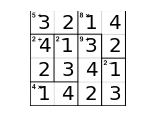

In [85]:
fig = plt.figure(figsize=(2, 2), dpi=100)

plt.axis('off')
plt.tight_layout()

plt.imshow(sample4x4_crop, cmap=mpl.cm.Greys_r)
for k,v in solution.items():
    plt.annotate('{}'.format(v), xy=(k[0]*50+15,k[1]*50+35), fontsize=20)

# Success!

In [255]:
from collections import defaultdict

memo = defaultdict(int)

def find_answer(full_number, current_number, coins, count=0):
    if current_number in memo:
        memo[full_number]=count + memo[current_number]
        return count + memo[number]
    
    if current_number == 0:
        memo[full_number]=count
        return count
    
    else:
        coins = sorted(coins, reverse=True)
        #print(coins)
        mods = []
        min_mod = 100000000
        for coin in coins:
            mods.append(current_number%coin)
        
        bad_coins = []
        for i,coin in enumerate(coins):
            for mod in mods:
                if coin<mod:
                    bad_coins.append(i)
                    break
        
        new_coins = [coins[j] for j in range(len(coins)) if j not in bad_coins]
        new_mods = [mods[j] for j in range(len(coins)) if j not in bad_coins]
        
        #print(mods)
        print(len(new_mods))
        for k, mod in enumerate(new_mods):
            print(mod, new_coins[k])
            if mod < min_mod and current_number-new_coins[k]>=0:
                min_mod = mod
                min_index = k
        
        #print(min_index)
        #print(coins[min_index])
        current_number-=new_coins[min_index]
        count+=1
        #print(current_number,count)
        return find_answer(full_number,current_number,coins,count)

for j in range(12):
    #print('This is {}'.format(j))
    find_answer(j, j, [1,6,7,456,678])
 
memo[123456]

5
1 678
1 456
1 7
1 6
0 1
4
2 678
2 456
2 7
2 6


UnboundLocalError: local variable 'min_index' referenced before assignment

In [246]:
for k,v in memo.items():
    if k == 1000:
        break
    print(k,v)

0 0
1 1
2 2
3 3
4 4
5 5
6 1
7 1
8 2
9 3
10 4
11 5
12 2
13 3
14 2
15 3
16 4
17 5
18 3
19 4
20 5
21 3
22 4
23 5
24 4
25 5
26 6
27 7
28 4
29 5
30 5
31 6
32 7
33 8
34 9
35 5
36 6
37 7
38 8
39 9
40 10
41 11
42 6
43 7
44 8
45 9
46 10
47 11
48 7
49 7
50 8
51 9
52 10
53 11
54 8
55 9
56 8
57 9
58 10
59 11
60 9
61 10
62 11
63 9
64 10
65 11
66 10
67 11
68 12
69 13
70 10
71 11
72 11
73 12
74 13
75 14
76 15
77 11
78 12
79 13
80 14
81 15
82 16
83 17
84 12
85 13
86 14
87 15
88 16
89 17
90 13
91 13
92 14
93 15
94 16
95 17
96 14
97 15
98 14
99 15
100 16
101 17
102 15
103 16
104 17
105 15
106 16
107 17
108 16
109 17
110 18
111 19
112 16
113 17
114 17
115 18
116 19
117 20
118 21
119 17
120 18
121 19
122 20
123 21
124 22
125 23
126 18
127 19
128 20
129 21
130 22
131 23
132 19
133 19
134 20
135 21
136 22
137 23
138 20
139 21
140 20
141 21
142 22
143 23
144 21
145 22
146 23
147 21
148 22
149 23
150 22
151 23
152 24
153 25
154 22
155 23
156 23
157 24
158 25
159 26
160 27
161 23
162 24
163 25
164 26
165 27
16